## GGR274: Introductory Computation and Data Science for the Social Sciences 
## Is there a higher prevalence of diabetes in low income neighbourhoods?

### Name:  Sabrina Knaudt


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

income_df = pd.read_excel('/home/jovyan/ggr274-20251/project/presentation/data/income_Toronto_2021_7.xlsx', header=11)
diabetes_df = pd.read_excel('/home/jovyan/ggr274-20251/project/presentation/data/AHD_Diabetes_FY2022.xlsx', header=5)

## Introduction

- Association of neighbourhood quintiles (based on adult low income percents) and prevalence of diabetes using bootstraped confidence intervals

- Krieger N. (2001). Theories for social epidemiology in the 21st century: An ecosocial perspective. International journal of epidemiology, 30(4), 668–677.
- Murdock, K. W., LeRoy, A. S., Lacourt, T. E., Duke, D. C., Heijnen, C. J., & Fagundes, C. P. (2016). Executive Functioning and Diabetes: The Role of Anxious Arousal and Inflammation. Psychoneuroendocrinology, 71, 102–109. 



## Methods
- Data wrangling 
- Bootstrap confidence intervals

## Data wrangling

- Wrangling two datasets: one for income data (**income_df**) and one for diabetes prevalence (**diabetes_df**).   Renaming columns for clarity, such as **'Unnamed: 0'** to **'neighbourhood_ID'** and **'In LICO-AT'** to **'low_income_population'**. Select relevant columns: **'neighbourhood_ID', 'neighbourhood_name', 'adult_population',** and **'adult_percent_low_income'.**
- For the diabetes dataset, I also only kept key columns: **'total_diabetes_count', 'total_neighb_pop', 'total_prevelance'** and removed citywide statistics for both dataframes (row 158) using the **drop()** method.

## Data wrangling
- I then categorized neighborhoods into income quintiles based on **'adult_percent_low_income'** using the **quantile()** method with thresholds at 0.20, 0.40, 0.60, and 0.80. The **apply()** method assigned a quintile label to each neighborhood based on these thresholds.


In [33]:
# clean income df
rename_cols = {
    'Unnamed: 0' : 'neighbourhood_ID',
    'Unnamed: 1' : 'neighbourhood_name',
    'Total - Population to whom Low Income Concepts Are Applicable (Denominator)^' : 'neighbourhood_population',
    'In LICO-AT' : 'low_income_population',
    'In LICO-AT (%)' : 'neighbourhood_percent_low_income',
    'Total - Population to whom Low Income Concepts Are Applicable (18-64 yrs).1' : 'adult_population',
    'In LIM-AT \n(18-64 yrs)' : 'adult_low_income',
    'In LIM-AT \n(18-64 yrs) (%)' : 'adult_percent_low_income'
}

income_cols = ['neighbourhood_ID', 'neighbourhood_name', 'adult_population',
          'adult_low_income', 'adult_percent_low_income']

income_df_clean = income_df.copy()
income_df_clean = income_df_clean.rename(columns=rename_cols)
income_df_clean = income_df_clean[income_cols]

# drop the row that includes citywide statistics, need to remove for significance testing
income_df_clean = income_df_clean.drop(158)

In [34]:
income_df_clean

,neighbourhood_ID,neighbourhood_name,adult_population,adult_low_income,adult_percent_low_income
0,1.0,West Humber-Clairville,22305,1720,5.2
1,2.0,Mount Olive-Silverstone-Jamestown,19995,2560,8.2
2,3.0,Thistletown-Beaumond Heights,6280,635,6.4
3,4.0,Rexdale-Kipling,6630,705,6.8
4,5.0,Elms-Old Rexdale,5980,595,6.4
...,...,...,...,...,...
153,170.0,Yonge-Bay Corridor,10745,2595,20.5
154,171.0,Junction-Wallace Emerson,16815,1685,7.3
155,172.0,Dovercourt Village,8745,825,6.7
156,173.0,North Toronto,12500,2120,13.4


In [35]:
# clean diabetes df

cols = diabetes_df.columns

diabetes_rename_cols = {
    cols[0] : 'neighbourhood_ID', 
    cols[1] : 'neighbourhood_name', 
    cols[2] : 'male_diabetes_count',
    cols[3] : 'female_diabetes_count',
    cols[4] : 'total_diabetes_count',
    cols[5] : 'male_neighb_pop',
    cols[6] : 'female_neighb_pop',
    cols[7] : 'total_neighb_pop',
    cols[19] : 'male_prevalence', # ages 20+, non age standardized prevelance (/100)
    cols[20] : 'female_prevalence',
    cols[21] : 'total_diabetes_prevalence',
}

diabetes_cols = ['neighbourhood_ID', 'neighbourhood_name', 'total_diabetes_count', 'total_neighb_pop', 'total_diabetes_prevalence']

diabetes_df_clean = diabetes_df.copy()
diabetes_df_clean = diabetes_df_clean.rename(columns=diabetes_rename_cols)
diabetes_df_clean = diabetes_df_clean[diabetes_cols]

# drop the row that includes citywide statistics, need to remove for significance testing
diabetes_df_clean = diabetes_df_clean.drop(158)

In [36]:
diabetes_df_clean

,neighbourhood_ID,neighbourhood_name,total_diabetes_count,total_neighb_pop,total_diabetes_prevalence
0,1.0,West Humber-Clairville,5365,31085,17.3
1,2.0,Mount Olive-Silverstone-Jamestown,4732,26164,18.1
2,3.0,Thistletown-Beaumond Heights,1546,9095,17.0
3,4.0,Rexdale-Kipling,1504,9290,16.2
4,5.0,Elms-Old Rexdale,1298,7897,16.4
...,...,...,...,...,...
153,170.0,Yonge-Bay Corridor,625,14982,4.2
154,171.0,Junction-Wallace Emerson,2184,21437,10.2
155,172.0,Dovercourt Village,1042,11631,9.0
156,173.0,North Toronto,964,14910,6.5


In [37]:
# income quintiles 
q5 = income_df_clean['adult_percent_low_income'].quantile(0.20) #lowest percent low income adult neighbourhoods
q4 = income_df_clean['adult_percent_low_income'].quantile(0.40)
q3 = income_df_clean['adult_percent_low_income'].quantile(0.60)
q2 = income_df_clean['adult_percent_low_income'].quantile(0.80) #highest percent

def assign_quintile(q):
    if q <= q5:
        return 'Fifth quintile' #highest SES neighbourhoods
    elif q <= q4:
        return 'Fourth quintile'
    elif q <= q3:
        return 'Third quintile'
    elif q <= q2:
        return 'Second quintile'
    else:
        return 'First quintile' #lowest SES neighbourhoods

# making a copy to not overwrite the dataframe, best practice 
income_quintiles_df = income_df_clean.copy()
income_quintiles_df['income_quintile'] = income_quintiles_df['adult_percent_low_income'].apply(assign_quintile)

In [38]:
income_quintiles_df

,neighbourhood_ID,neighbourhood_name,adult_population,adult_low_income,adult_percent_low_income,income_quintile
0,1.0,West Humber-Clairville,22305,1720,5.2,Fifth quintile
1,2.0,Mount Olive-Silverstone-Jamestown,19995,2560,8.2,Second quintile
2,3.0,Thistletown-Beaumond Heights,6280,635,6.4,Fourth quintile
3,4.0,Rexdale-Kipling,6630,705,6.8,Third quintile
4,5.0,Elms-Old Rexdale,5980,595,6.4,Fourth quintile
...,...,...,...,...,...,...
153,170.0,Yonge-Bay Corridor,10745,2595,20.5,First quintile
154,171.0,Junction-Wallace Emerson,16815,1685,7.3,Third quintile
155,172.0,Dovercourt Village,8745,825,6.7,Third quintile
156,173.0,North Toronto,12500,2120,13.4,First quintile


In [39]:
# check if our sorting makes sense
income_quintiles_df['income_quintile'].value_counts()

income_quintile
Fifth quintile     34
Third quintile     32
First quintile     32
Second quintile    31
Fourth quintile    29
Name: count, dtype: int64

In [40]:
# visualization of quintiles and low income percents, sanity check
import altair as alt

qsort = ['First quintile', 'Second quintile', 'Third quintile', 'Fourth quintile', 'Fifth quintile']

quintile_chart = alt.Chart(income_quintiles_df).mark_bar().encode(
    alt.X('income_quintile:N', title='Income quintile', sort=qsort),
    alt.Y('mean(adult_percent_low_income):Q', title='Average neighbourhood percent of low income adults'),
    tooltip=[
    alt.Tooltip('income_quintile:O', title='Income quintile'),
    alt.Tooltip('mean(adult_percent_low_income):Q', title='Avg. % Low Income', format='.2f')
    ]
).properties(title='Average neighbourhood percent of low income adults by quintile', width=400)

In [41]:
quintile_chart

alt.Chart(...)

In [42]:
# merging the two dataframes

# first, making sure the datasets can be indiscriminately concatenated horizontally 
test = diabetes_df_clean['neighbourhood_name'] == income_quintiles_df['neighbourhood_name']
test.sum() # will add all the true values and equal the number of rows we have

# concatenating the two dataframes 
diabetes_income = pd.concat([income_quintiles_df, diabetes_df_clean], axis=1)

# drop duplicate columns
diabetes_income = diabetes_income.T.drop_duplicates().T

## Data wrangling
- Finally, I merged the datasets by matching neighborhoods and concatenating them with **pd.concat()**, ensuring no duplicate columns remained using **drop_duplicates()**. This produced the diabetes_income dataset, combining both income quintile and diabetes data for further analysis.

In [43]:
income_df

,Unnamed: 0,Unnamed: 1,Total - Population to whom Low Income Concepts Are Applicable (Denominator)^,In LICO-AT,In LICO-AT (%),Total - Population to whom Low Income Concepts Are Applicable (0-17 yrs),In LICO-AT \n(0-17 yrs),In LICO-AT \n(0-17 yrs) (%),Total - Population to whom Low Income Concepts Are Applicable (0-5 yrs),In LICO-AT \n(0-5 yrs),...,In LIM-AT \n(0-17 yrs) (%),Total - Population to whom Low Income Concepts Are Applicable (0-5 yrs).1,In LIM-AT \n(0-5 yrs),In LIM-AT \n(0-5 yrs) (%),Total - Population to whom Low Income Concepts Are Applicable (18-64 yrs).1,In LIM-AT \n(18-64 yrs),In LIM-AT \n(18-64 yrs) (%),Total - Population to whom Low Income Concepts Are Applicable (65+ yrs).1,In LIM-AT \n(65+ yrs),In LIM-AT \n(65+ yrs) (%)
0,1.0,West Humber-Clairville,32905,2450,7.4,5300,285,0.9,1670,100,...,1.7,1670,210,0.6,22305,1720,5.2,5295,590,1.8
1,2.0,Mount Olive-Silverstone-Jamestown,31195,2705,8.7,7120,670,2.1,2020,210,...,5.1,2015,490,1.6,19995,2560,8.2,4130,700,2.2
2,3.0,Thistletown-Beaumond Heights,9845,725,7.4,1855,140,1.4,590,60,...,3.1,575,95,1.0,6280,635,6.4,1740,220,2.2
3,4.0,Rexdale-Kipling,10380,775,7.5,1895,145,1.4,635,50,...,3.3,620,110,1.1,6630,705,6.8,1850,355,3.4
4,5.0,Elms-Old Rexdale,9360,715,7.6,2000,210,2.2,565,60,...,4.2,580,120,1.3,5980,595,6.4,1390,175,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,171.0,Junction-Wallace Emerson,23230,1945,8.4,3540,190,0.8,1395,45,...,1.5,1370,125,0.5,16815,1685,7.3,2960,610,2.6
155,172.0,Dovercourt Village,12315,1040,8.4,1645,80,0.6,530,10,...,1.1,530,30,0.2,8745,825,6.7,1910,235,1.9
156,173.0,North Toronto,15885,1975,12.4,1590,190,1.2,615,65,...,2.0,620,100,0.6,12500,2120,13.4,1805,505,3.2
157,174.0,South Eglinton-Davisville,22715,2450,10.8,2520,240,1.1,1035,85,...,1.7,1020,125,0.5,17170,2455,10.8,3045,640,2.8


In [44]:
diabetes_df

,Unnamed: 0,Unnamed: 1,Male,Female,Total,Male.1,Female.1,Total.1,Male.2,Female.2,...,Female.12,Total.12,"Rate Ratio**, Total.4","H/ L/ NS, Total.4","(95% CI) LL, Male.4","(95% CI) UL, Male.4","(95% CI) LL, Female.4","(95% CI) UL, Female.4","(95% CI) LL, Total.4","(95% CI) UL, Total.4"
0,1.0,West Humber-Clairville,2745,2620,5365,15507,15578,31085,18.4,17.5,...,41.1,43.7,1.41,H,44.9,48.5,39.4,42.7,42.5,44.9
1,2.0,Mount Olive-Silverstone-Jamestown,2358,2374,4732,12720,13444,26164,19.4,19.0,...,44.3,45.9,1.48,H,45.5,49.6,42.4,46.3,44.5,47.3
2,3.0,Thistletown-Beaumond Heights,780,766,1546,4473,4622,9095,16.7,16.3,...,36.0,37.5,1.21,H,36.1,42.2,33.2,38.8,35.4,39.5
3,4.0,Rexdale-Kipling,737,767,1504,4577,4713,9290,15.0,14.7,...,34.7,35.6,1.15,H,33.7,39.7,32.1,37.3,33.6,37.6
4,5.0,Elms-Old Rexdale,639,659,1298,3892,4005,7897,16.4,16.6,...,35.3,37.5,1.21,H,36.6,43.7,32.0,38.5,35.1,39.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,171.0,Junction-Wallace Emerson,1081,1103,2184,10631,10806,21437,11.9,12.5,...,35.9,36.8,1.19,H,35.5,40.4,33.7,38.1,35.2,38.5
155,172.0,Dovercourt Village,519,523,1042,5671,5960,11631,10.1,9.9,...,31.5,32.7,1.05,NS,31.0,37.2,28.8,34.2,30.6,34.7
156,173.0,North Toronto,430,534,964,6738,8172,14910,9.3,8.6,...,23.3,24.2,0.78,L,22.6,29.1,21.0,25.7,22.3,26.1
157,174.0,South Eglinton-Davisville,674,718,1392,9711,11701,21412,8.5,7.1,...,18.0,20.4,0.66,L,22.0,26.5,16.4,19.6,19.1,21.7


In [45]:
diabetes_income

,neighbourhood_ID,neighbourhood_name,adult_population,adult_low_income,adult_percent_low_income,income_quintile,total_diabetes_count,total_neighb_pop,total_diabetes_prevalence
0,1.0,West Humber-Clairville,22305,1720,5.2,Fifth quintile,5365,31085,17.3
1,2.0,Mount Olive-Silverstone-Jamestown,19995,2560,8.2,Second quintile,4732,26164,18.1
2,3.0,Thistletown-Beaumond Heights,6280,635,6.4,Fourth quintile,1546,9095,17.0
3,4.0,Rexdale-Kipling,6630,705,6.8,Third quintile,1504,9290,16.2
4,5.0,Elms-Old Rexdale,5980,595,6.4,Fourth quintile,1298,7897,16.4
...,...,...,...,...,...,...,...,...,...
153,170.0,Yonge-Bay Corridor,10745,2595,20.5,First quintile,625,14982,4.2
154,171.0,Junction-Wallace Emerson,16815,1685,7.3,Third quintile,2184,21437,10.2
155,172.0,Dovercourt Village,8745,825,6.7,Third quintile,1042,11631,9.0
156,173.0,North Toronto,12500,2120,13.4,First quintile,964,14910,6.5


## Bootstrap confidence intervals:
- Applied bootstrapping to estimate the mean difference in diabetes prevalence between selected pairs of quintiles. 
> - Comparisons included adjacent quintiles, high vs. low extremes, and other meaningful combinations.
> - q5 - q4; … ; q2 - q1; as well as: q5 - 1; q4 - q1; q3 - q1; q4 - q2


- This was done through custom functions that sampled the data with replacement using **diabetes_income.sample(frac=1, replace=True)**. Within each resample, the difference in mean total_diabetes_prevalence between two specified quintiles was calculated. Each function returned a single bootstrapped mean difference.
<br><br>
- Each comparison was repeated 5000 times in a loop **for _ in range(5000)** to generate a distribution of bootstrapped differences. These distributions allow us to estimate confidence intervals.


## Results
- Distribution of bootstrapped mean difference in diabetes prevalence among quintile comparisons:

In [46]:
q_diabetes_income_chart = alt.Chart(diabetes_income).mark_bar().encode(
    alt.X('income_quintile:O', sort=qsort, title='Income quintile'),
    alt.Y('mean(total_diabetes_prevalence):Q', title='Mean rate of diabetes'),
    tooltip=[
        alt.Tooltip('mean(total_diabetes_prevalence):Q', title='Mean diabetes prevalence', format='.2f'),
        alt.Tooltip('mean(adult_percent_low_income):Q', title='Avg. % Low Income', format='.2f')
    ]
).properties(title= 'Mean diabetes prevalence by income quintile', height=400, width=500)

q_diabetes_income_chart

alt.Chart(...)

In [47]:
mean_incidence = diabetes_income.groupby(by='income_quintile')['total_diabetes_prevalence'].mean()
mean_incidence = pd.DataFrame(mean_incidence).reset_index()

category_order = ['First quintile', 'Second quintile', 'Third quintile', 'Fourth quintile', 'Fifth quintile']

mean_incidence['income_quintile'] = pd.Categorical(
    mean_incidence['income_quintile'], 
    categories=category_order, 
    ordered=True
)

mean_incidence = mean_incidence.sort_values('income_quintile').reset_index(drop=True)
mean_incidence

,income_quintile,total_diabetes_prevalence
0,First quintile,9.771875
1,Second quintile,13.125806
2,Third quintile,12.63125
3,Fourth quintile,12.662069
4,Fifth quintile,11.758824


In [48]:
q1 = diabetes_income['income_quintile'] == 'First quintile' #lowest neighbourhood SES
q2 = diabetes_income['income_quintile'] == 'Second quintile'
q3 = diabetes_income['income_quintile'] == 'Third quintile'
q4 = diabetes_income['income_quintile'] == 'Fourth quintile'
q5 = diabetes_income['income_quintile'] == 'Fifth quintile' #highest neighbourhood SES

def bs_q5_q4():
    bssample = diabetes_income.sample(frac = 1, replace=True)
    
    bs_mean_diff = (bssample.loc[q5, 'total_diabetes_prevalence'].mean() - 
                   bssample.loc[q4, 'total_diabetes_prevalence'].mean())
    return bs_mean_diff

def bs_q4_q3():
    bssample = diabetes_income.sample(frac = 1, replace=True)
    
    bs_mean_diff = (bssample.loc[q4, 'total_diabetes_prevalence'].mean() - 
                   bssample.loc[q3, 'total_diabetes_prevalence'].mean())
    return bs_mean_diff

def bs_q3_q2():
    bssample = diabetes_income.sample(frac = 1, replace=True)
    
    bs_mean_diff = (bssample.loc[q3, 'total_diabetes_prevalence'].mean() - 
                   bssample.loc[q2, 'total_diabetes_prevalence'].mean())
    return bs_mean_diff

def bs_q2_q1():
    bssample = diabetes_income.sample(frac = 1, replace=True)
    
    bs_mean_diff = (bssample.loc[q2, 'total_diabetes_prevalence'].mean() - 
                   bssample.loc[q1, 'total_diabetes_prevalence'].mean())
    return bs_mean_diff

def bs_q5_q1():
    bssample = diabetes_income.sample(frac = 1, replace=True)
    
    bs_mean_diff = (bssample.loc[q5, 'total_diabetes_prevalence'].mean() - 
                   bssample.loc[q1, 'total_diabetes_prevalence'].mean())
    return bs_mean_diff

def bs_q4_q2():
    bssample = diabetes_income.sample(frac = 1, replace=True)
    
    bs_mean_diff = (bssample.loc[q4, 'total_diabetes_prevalence'].mean() - 
                   bssample.loc[q2, 'total_diabetes_prevalence'].mean())
    return bs_mean_diff

def bs_q4_q1():
    bssample = diabetes_income.sample(frac = 1, replace=True)
    
    bs_mean_diff = (bssample.loc[q4, 'total_diabetes_prevalence'].mean() - 
                   bssample.loc[q1, 'total_diabetes_prevalence'].mean())
    return bs_mean_diff

def bs_q3_q1():
    bssample = diabetes_income.sample(frac = 1, replace=True)
    
    bs_mean_diff = (bssample.loc[q3, 'total_diabetes_prevalence'].mean() - 
                   bssample.loc[q1, 'total_diabetes_prevalence'].mean())
    return bs_mean_diff

In [49]:
boots_q5_q4 = []

for _ in range(5000):
    boots_q5_q4.append(bs_q5_q4())
    
boots_q4_q3 = []

for _ in range(5000):
    boots_q4_q3.append(bs_q4_q3())

boots_q3_q2 = []

for _ in range(5000):
    boots_q3_q2.append(bs_q3_q2())

boots_q2_q1 = []

for _ in range(5000):
    boots_q2_q1.append(bs_q2_q1())

boots_q5_q1 = []

for _ in range(5000):
    boots_q5_q1.append(bs_q5_q1())
    
boots_q4_q2 = []

for _ in range(5000):
    boots_q4_q2.append(bs_q4_q2())

boots_q4_q1 = []

for _ in range(5000):
    boots_q4_q1.append(bs_q4_q1())
    
boots_q3_q1 = []

for _ in range(5000):
    boots_q3_q1.append(bs_q3_q1())

In [50]:
ci_q5_q4 = np.percentile(boots_q5_q4, 2.5), np.percentile(boots_q5_q4, 97.5) 

In [51]:
ci_q4_q3 = np.percentile(boots_q4_q3, 2.5), np.percentile(boots_q4_q3, 97.5) 

In [52]:
ci_q3_q2 = np.percentile(boots_q3_q2, 2.5), np.percentile(boots_q3_q2, 97.5) 

In [53]:
ci_q2_q1 = np.percentile(boots_q2_q1, 2.5), np.percentile(boots_q2_q1, 97.5) 

In [54]:
ci_q5_q1 = np.percentile(boots_q5_q1, 2.5), np.percentile(boots_q5_q1, 97.5) 

In [55]:
ci_q4_q2 = np.percentile(boots_q4_q2, 2.5), np.percentile(boots_q4_q2, 97.5) 

In [56]:
ci_q4_q1 = np.percentile(boots_q4_q1, 2.5), np.percentile(boots_q4_q1, 97.5) 

In [57]:
ci_q3_q1 = np.percentile(boots_q3_q1, 2.5), np.percentile(boots_q3_q1, 97.5) 

95% CI: (-2.965961374832067, 1.2583758672699874)


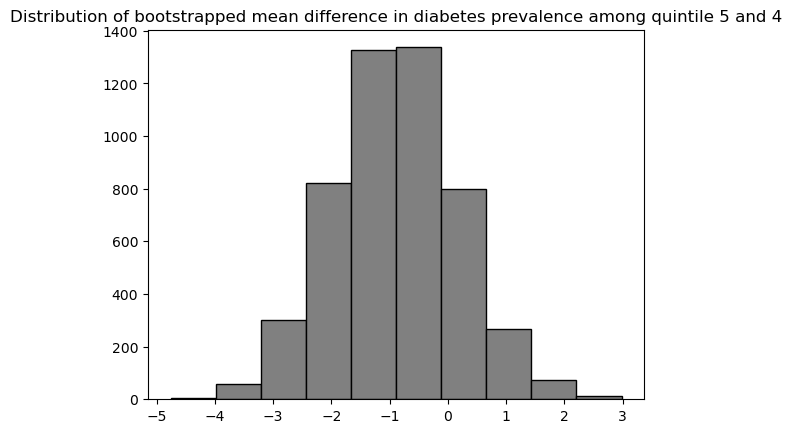

In [58]:
import matplotlib.pyplot as plt 

print(f"95% CI: {ci_q5_q4}")

plt.hist(boots_q5_q4, color = 'grey', edgecolor = 'black')
plt.title('Distribution of bootstrapped mean difference in diabetes prevalence among quintile 5 and 4');

95% CI: (-2.054814516129036, 2.061820471001502)


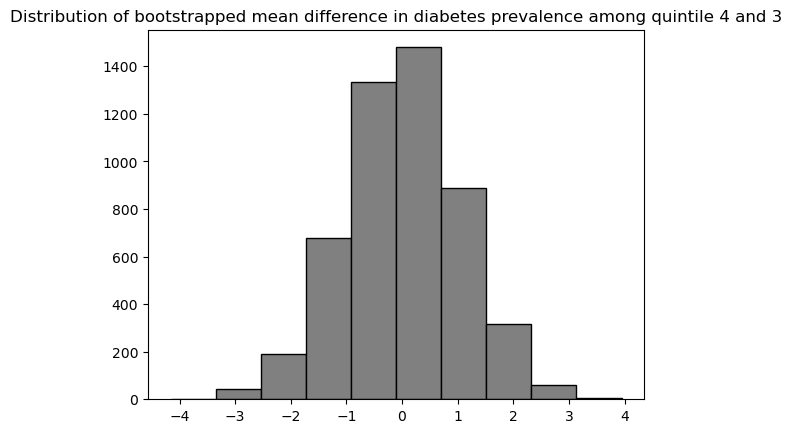

In [59]:
print(f"95% CI: {ci_q4_q3}")

plt.hist(boots_q4_q3, color = 'grey', edgecolor = 'black')
plt.title('Distribution of bootstrapped mean difference in diabetes prevalence among quintile 4 and 3');

95% CI: (-2.5869006641366235, 1.628862978237977)


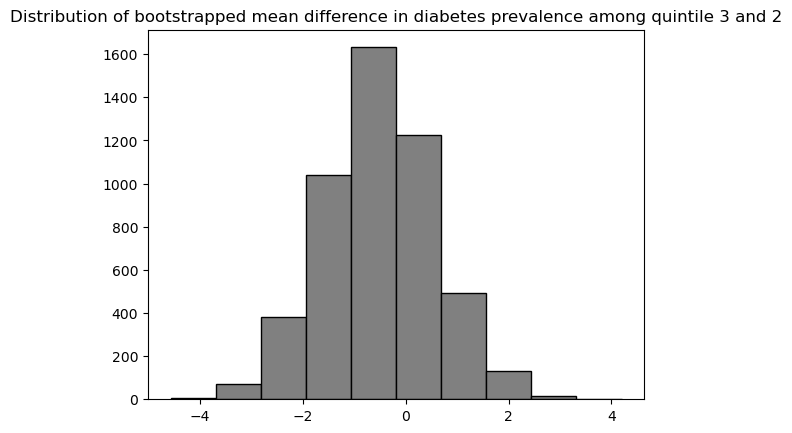

In [60]:
print(f"95% CI: {ci_q3_q2}")

plt.hist(boots_q3_q2, color = 'grey', edgecolor = 'black')
plt.title('Distribution of bootstrapped mean difference in diabetes prevalence among quintile 3 and 2');

95% CI: (1.199966931216934, 5.418997085320616)


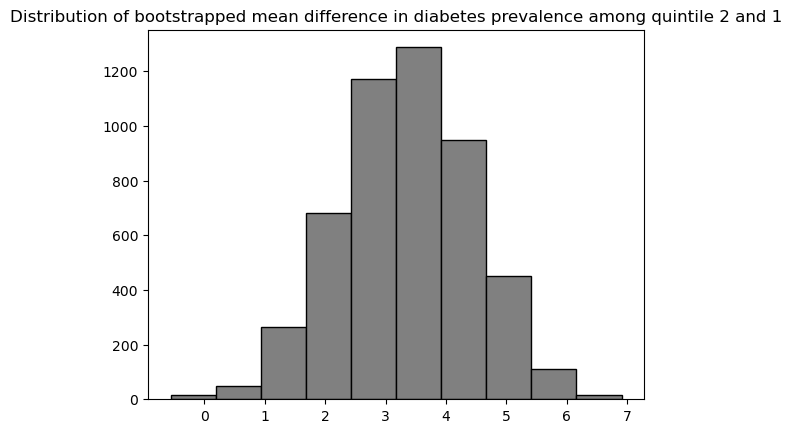

In [61]:
print(f"95% CI: {ci_q2_q1}")

plt.hist(boots_q2_q1, color = 'grey', edgecolor = 'black')
plt.title('Distribution of bootstrapped mean difference in diabetes prevalence among quintile 2 and 1');

95% CI: (-0.20181318082788788, 4.200391079508727)


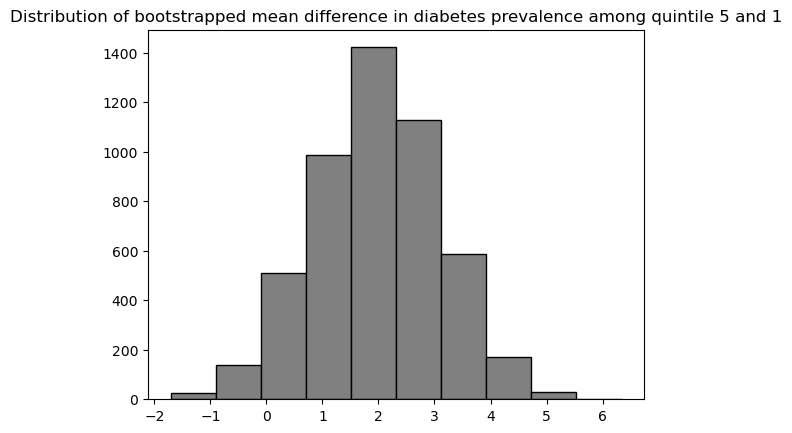

In [62]:
print(f"95% CI: {ci_q5_q1}")

plt.hist(boots_q5_q1, color = 'grey', edgecolor = 'black')
plt.title('Distribution of bootstrapped mean difference in diabetes prevalence among quintile 5 and 1');

95% CI: (0.8433674242424222, 4.933237730737731)


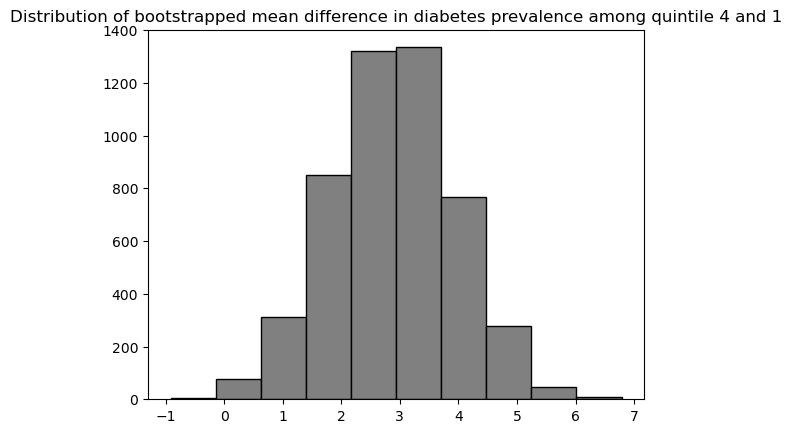

In [63]:
print(f"95% CI: {ci_q4_q1}")

plt.hist(boots_q4_q1, color = 'grey', edgecolor = 'black')
plt.title('Distribution of bootstrapped mean difference in diabetes prevalence among quintile 4 and 1');

95% CI: (-2.5091205061366413, 1.6382242465951833)


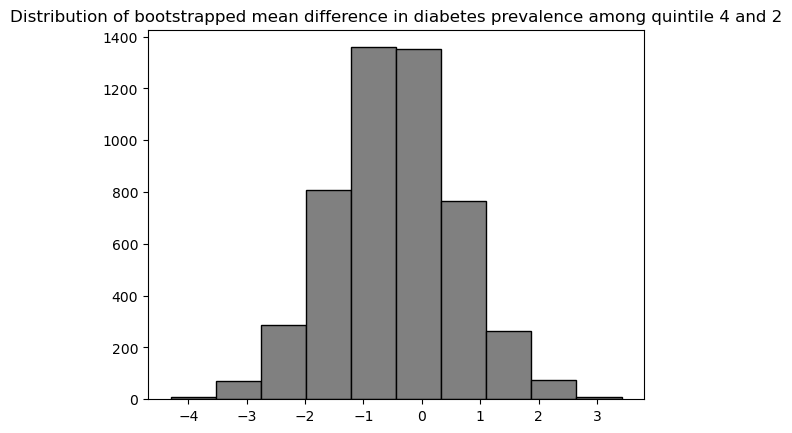

In [64]:
print(f"95% CI: {ci_q4_q2}")

plt.hist(boots_q4_q2, color = 'grey', edgecolor = 'black')
plt.title('Distribution of bootstrapped mean difference in diabetes prevalence among quintile 4 and 2');

95% CI: (0.7682473832528259, 4.939592513342516)


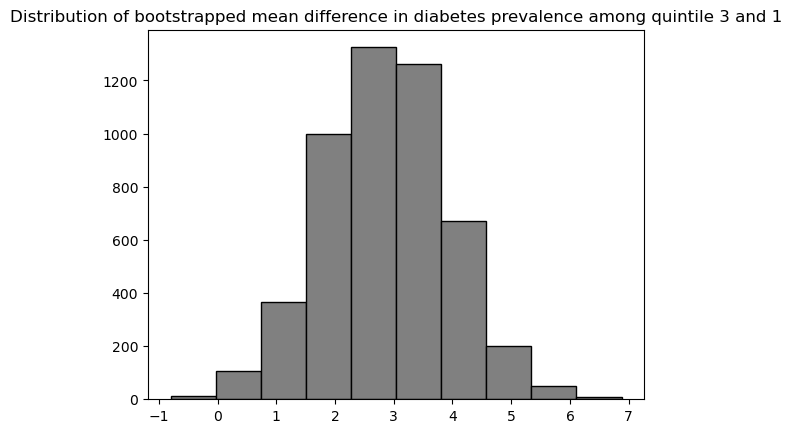

In [65]:
print(f"95% CI: {ci_q3_q1}")

plt.hist(boots_q3_q1, color = 'grey', edgecolor = 'black')
plt.title('Distribution of bootstrapped mean difference in diabetes prevalence among quintile 3 and 1');

## Results
- Non-significant comparisons: 
<br>quintile 5 - quintile 4: 95% CI: (-2.93, 1.19)
<br>quintile 4 - quintile 3: 95% CI: (-1.96, 1.96)
<br>quintile 3 - quintile 2: 95% CI: (-2.61, 1.62)
<br>quintile 5 - quintile 1: 95% CI: (-0.21, 4.16)
<br>quintile 4 - quintile 2: 95% CI: (-2.56, 1.66)
<br>
- Positive significance: 
<br>quintile 4 - quintile 1: 95% CI: (0.80, 4.98)
<br>quintile 3 - quintile 1: 95% CI: (0.78, 4.98)
<br>quintile 2 - quintile 1: 95% CI: (1.20, 5.45)

## Conclusion

- Theoretically, we expected distributions to fall left of zero. Higher quintile -> smaller percent low income adults -> lower diabetes prevalence. 
> Interestingly, we saw POSTIVE bootstrapped mean differences, meaning lower quintiles had lower diabetes prevalence. Quintile 4 - 1; Quintile 3 -1; Quintile 2 - 1
- No other significant trend 

In [66]:
# All our positive significant results involved the first quintile
q_diabetes_income_chart

alt.Chart(...)

In [67]:
diabetes_income_chart = alt.Chart(diabetes_income).mark_circle().encode(
    alt.X('adult_percent_low_income:Q', title='Neighbourhood percent of low income adults'),
    alt.Y('total_diabetes_prevalence:Q', title='Neighbourhood prevalence of diabetes'),
    tooltip=[
        alt.Tooltip('neighbourhood_name:N', title='Neighbourhood')
    ]
).properties(title='Neighbourhood prevalence of diabetes and neighbourhood percent of low income adults', width=400)

In [68]:
diabetes_income_chart

alt.Chart(...)

### This could be because of..

- Is there a higher prevalence of diabetes in low income neighbourhoods?
>Is there a higher neighbourhood prevalence of diabetes where there are more low income adults?

- If we want to see the effect SES has on your chance of developing diabetes. We have to compare compare individuals to THEMSELVES. So, for one data point I know your income and whether you do / do not have diabetes. This can be longitudinal or snapshot to see if there is an association with prevalence.
